# Stock Price Prediction, using SageMaker DeepAR


DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates:
- How to format Deutsche Börse maintained stock market data to be used as training input and prediction on DeepAR
- Usage of `Dynamic Features` on DeepAR, with metrices within the Deutsche Börse dataset used as dynamic features
- How to easily train an DeepAR Estimator and create a Predictor using DeepAR container image

Running the model training using the highest memory CPU based [ML instance type](https://aws.amazon.com/sagemaker/pricing/instance-types/) available on AWS at this time (`ml.c5.18xlarge`), it should take about 15 minutes to train the model if you use data sampled at daily interval.


In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Choice of Series

As we observed during data analysis phase that there are certain stocks that are clustered relatively more, based on their past price trends. Naturally, using these similarly moving stock would increase overall model performance, in absence of any other available external time series.

Therefore, like before, use the stocks of companies in automobile industry, and tjhe closing price of these series as the time series' of choice, for the model to build upon. THe difference here however is that, we do not have to specify which is the main series, and which ones are exogenous. DeepAR algorithm works to build a model that accounts for trends in all provided time series, and can generate forecast on any of those. This saves you the hassle of building different models for different time series.

Just like we used covariate time series in our custom RNN example, we can use such series on DeepAR, by using the Dynamic Features. The data formatting function works to take all covariate columns, and format those as dynamic features for each time series.

So, in effect, following the configuration below, you end up having 5 time series' - the closing prices of the 5 stocks, each with 3 dynamic feature series' - opening price, and minimum and maximum prices.

In [2]:
# Define parameters
interval = 'D' #Use D or H

assert interval == 'D' 

if interval == 'D':
    prediction_length = 65 #when interval = D    
    context_length = 65
    
mnemonics = ['CON','DAI','PAH3','BMW','VOW3']
target_column = 'EndPrice'
covariate_columns = ['StartPrice', 'MinPrice', 'MaxPrice']

In [3]:
# Define IAM role and session
import sagemaker
role = sagemaker.get_execution_role()
session = sagemaker.Session()

#Obtain container image URI for SageMaker-DeepAR algorithm, based on region
region = session.boto_region_name
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")
print("Model will be trained using container image : {}".format(image_name))

#Define training data location
s3_data_key = 'dbg-stockdata/source'
s3_bucket = session.default_bucket()
s3_output_path = "s3://{}/{}/{}/output".format(s3_bucket, s3_data_key, interval)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


Model will be trained using container image : 522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest


## Training Data

During data preparation steps, you uploaded the resampled data to your S3 bucket, attached to your SageMaker session, under an appropriate prefix, depending on resampling interval. 

In order to use the data for DeepAr however, you'll need to do some preprocessing to have the data formatted following [DeepAR Input/Output interface](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput). 
The function named `deeparize` does this transformation.

In [4]:
%%time
metrics=[]
metrics.extend(covariate_columns)
metrics.append(target_column)

import boto3
import pandas as pd
import io

# Function to Format DBG stock market data into a format suitable for DeepAR algorithm
def deeparize(stockdata, stocksymbols, interval, metrices = None):
    data_feed = pd.DataFrame()
    data_feed['CalcDateTime'] = pd.to_datetime(pd.Series(sorted(list(stockdata.CalcDateTime.unique()))),infer_datetime_format=True)
    data_feed.index = data_feed['CalcDateTime']
    data_feed.drop('CalcDateTime', axis=1, inplace = True)

    for mnemonic in stocksymbols:

        mnemonic_data = stockdata[stockdata.Mnemonic == mnemonic].copy()
        mnemonic_data.index = mnemonic_data['CalcDateTime']
        mnemonic_data = mnemonic_data.sort_index()
        mnemonic_data = mnemonic_data.iloc[:,-6:]
        if metrices is None:
            metrices = mnemonic_data.columns.values
        for col in metrices:
            metric_col = mnemonic_data[col].to_frame()
            metric_col.columns = ["{}-{}".format(mnemonic,col)]
            data_feed = data_feed.add(metric_col, fill_value=0)            
            
    data_feed = data_feed.resample(interval).mean()       
    data_feed.fillna(method='backfill', limit=1, inplace=True)
    data_feed.fillna(method='ffill', inplace=True) 
    data_feed.fillna(value=0, inplace=True)
    return data_feed

def load_resampled_from_s3(interval, bucket, s3_data_key, mnemonics=None, metrices = None):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/{}/resampled_stockdata.csv".format(s3_data_key, interval))
    loaded = pd.read_csv(io.BytesIO(obj['Body'].read()), parse_dates=True)
    if mnemonics is None:
        mnemonics = list(loaded.Mnemonic.unique())
    return deeparize(loaded, mnemonics, interval, metrices), mnemonics


stock_data_series, symbols = load_resampled_from_s3(interval, s3_bucket, s3_data_key, mnemonics, metrics)
print(stock_data_series.shape)
stock_data_series.head()

(484, 20)
CPU times: user 199 ms, sys: 8.56 ms, total: 207 ms
Wall time: 1.35 s


,BMW-EndPrice,BMW-MaxPrice,BMW-MinPrice,BMW-StartPrice,CON-EndPrice,CON-MaxPrice,CON-MinPrice,CON-StartPrice,DAI-EndPrice,DAI-MaxPrice,DAI-MinPrice,DAI-StartPrice,PAH3-EndPrice,PAH3-MaxPrice,PAH3-MinPrice,PAH3-StartPrice,VOW3-EndPrice,VOW3-MaxPrice,VOW3-MinPrice,VOW3-StartPrice
CalcDateTime,,,,,,,,,,,,,,,,,,,,
2017-07-03,83.12,83.52,81.86,81.96,190.30,191.55,189.55,189.80,64.14,64.48,63.60,63.68,50.66,50.73,49.62,49.69,136.10,136.70,134.50,134.85
2017-07-04,82.53,83.47,82.34,83.41,190.30,190.65,188.70,190.65,64.19,64.46,63.89,64.45,50.78,51.00,50.42,51.00,136.20,137.20,135.50,137.05
2017-07-05,81.48,81.84,81.19,81.76,189.20,189.95,188.65,189.75,63.54,63.89,63.25,63.88,50.37,50.77,50.10,50.71,135.55,136.55,134.60,136.20
2017-07-06,81.34,81.63,80.50,81.26,189.85,190.10,187.50,189.45,63.36,64.04,63.09,63.80,51.31,51.45,50.66,50.96,138.10,138.95,137.05,138.05
2017-07-07,81.26,81.35,80.83,81.19,188.90,189.15,187.20,188.70,63.44,63.57,63.13,63.21,51.17,51.26,50.80,51.09,138.75,138.75,137.60,138.05


Finally you split the formatted data into training and test channels and host on your S3 bucket, to be fed into estimator at training phase.


In [16]:
import numpy as np
selected = stock_data_series.sort_index()
train_set, test_set= np.split(selected, [int(.8 *len(selected))])

Now we build both the training and the testing set from target values and dynamic features.

In [17]:
import datetime
from gluonts.dataset.common import ListDataset
# Function to convert data frames containing time series data to JSON serialized data that DeepAR works with
def json_serialize(data, start, end, target_column, covariate_columns, interval):
    timeseries = {}

    for i, col in enumerate(data.columns):
        metric = col[col.find('-')+1:]
        stock = col[:col.find('-')]
        if metric == target_column:
            if stock in timeseries.keys():
                timeseries[stock]["target"] = data.iloc[:,i][start:end]
            else:
                timeseries[stock] = {}
                timeseries[stock]["start"] = str(pd.Timestamp(datetime.datetime.strptime(str(start), "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d %H:%M:%S"), freq = interval))
                timeseries[stock]["target"] = data.iloc[:,i][start:end]            
            print("Time series for {} added".format(stock))
        elif metric in covariate_columns:
            if stock in timeseries.keys():
                if "dynamic_feat" in timeseries[stock]:
                    dynamic_feat = timeseries[stock]["dynamic_feat"]
                    dynamic_feat.append(data.iloc[:,i][start:end])
                else:
                    dynamic_feat = []
                    dynamic_feat.append(data.iloc[:,i][start:end])
                    timeseries[stock]["dynamic_feat"] = dynamic_feat
            else:
                timeseries[stock] = {}
                dynamic_feat = []
                dynamic_feat.append(data.iloc[:,i])
                timeseries[stock]["dynamic_feat"] = dynamic_feat            
            print("Dynamic Feature - {} for {} added".format(metric, stock))
        else:
            pass

    json_data = ListDataset(
     data_iter=[
        {
            "start": pd.Timestamp(ts["start"], freq='1D'),
            "target": ts["target"].tolist(),  
            "feat_dynamic_real": [feat.tolist() for feat in ts["dynamic_feat"]]
        }
        for ts in timeseries.values()
    ], freq="1D"
    )
    return json_data



In [18]:
train_start_dt = train_set.index[0]
train_end_dt = train_set.index[-1]   
test_start_dt = test_set.index[0]
test_end_dt = test_set.index[-1]   

In [19]:
train_json = json_serialize(train_set, train_start_dt, train_end_dt, target_column, covariate_columns, interval)
test_json = json_serialize(test_set, test_start_dt, test_end_dt, target_column, covariate_columns, interval)

Time series for BMW added
Dynamic Feature - MaxPrice for BMW added
Dynamic Feature - MinPrice for BMW added
Dynamic Feature - StartPrice for BMW added
Time series for CON added
Dynamic Feature - MaxPrice for CON added
Dynamic Feature - MinPrice for CON added
Dynamic Feature - StartPrice for CON added
Time series for DAI added
Dynamic Feature - MaxPrice for DAI added
Dynamic Feature - MinPrice for DAI added
Dynamic Feature - StartPrice for DAI added
Time series for PAH3 added
Dynamic Feature - MaxPrice for PAH3 added
Dynamic Feature - MinPrice for PAH3 added
Dynamic Feature - StartPrice for PAH3 added
Time series for VOW3 added
Dynamic Feature - MaxPrice for VOW3 added
Dynamic Feature - MinPrice for VOW3 added
Dynamic Feature - StartPrice for VOW3 added
Time series for BMW added
Dynamic Feature - MaxPrice for BMW added
Dynamic Feature - MinPrice for BMW added
Dynamic Feature - StartPrice for BMW added
Time series for CON added
Dynamic Feature - MaxPrice for CON added
Dynamic Feature - M

## Model Training

Having obtained our training and testing data, we can now create a GluonTS estimator. In our example we will use the DeepAREstimator, an autoregressive RNN which was developed primarily for the purpose of time series forecasting. Note however that you can use a variety of different estimators. Also, since GluonTS is mainly target at probabilistic time series forecasting, lots of different output distributions can be specified. In the M5 case, we think that the NegativeBinomialOutput distribution best describes the output.

[DeepAR Hhyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html) allows you to control certain aspects of your NN architecture, such as number of layers, number of recurrent units in each layer, learning rate, prediction length and context (horizon and lag), dropout rate etc. In the cell above we configured some, so as to get good accuracy, within a reasonable training time, as suitable or this workshop.

In practice, you can use another valuable feature of SageMaker - [Hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) to conduct a sort of grid search over your hyperparameters space and find the best combination for your use case.

In [20]:
!pip install gluonts
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution import GaussianOutput
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=context_length,
    freq="D",
    num_layers=2, 
    num_cells=40, 
    dropout_rate=0.1,
    distr_output=GaussianOutput(),
    use_feat_dynamic_real=True,
    trainer=Trainer(epochs=100,
        learning_rate=1e-3,
        num_batches_per_epoch=50,
        batch_size=128,
        patience=40)
)

predictor = estimator.train(train_json)

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:33<00:00,  1.49it/s, epoch=100/100, avg_epoch_loss=1.51]


## Saving/Loading an existing model
A fitted model, i.e., a Predictor, can be saved and loaded back easily

In [ ]:
# save the trained model in tmp/
from pathlib import Path
predictor.serialize(Path("/tmp/"))

In [ ]:
# loads it back
from gluonts.model.predictor import Predictor
predictor_deserialized = Predictor.deserialize(Path("/tmp/"))

## Generating forecasts
Once the estimator is fully trained, we can generate predictions from it for the test values.


In [21]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_json,
    predictor=predictor,
    num_samples=65
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_json)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_json)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


Now we create a custom evaluator which, in addition to GluonTS's standard performance metrics, also returns MRMSSE (corresponding to the mean RMSSE). 

In [22]:
from gluonts.evaluation import Evaluator
    
class STOCKEvaluator(Evaluator):

    def get_metrics_per_ts(self, time_series, forecast):
        successive_diff = np.diff(time_series.values.reshape(len(time_series)))
        successive_diff = successive_diff ** 2
        successive_diff = successive_diff[:-prediction_length]
        denom = np.mean(successive_diff)
        pred_values = forecast.samples.mean(axis=0)
        true_values = time_series.values.reshape(len(time_series))[-prediction_length:]
        num = np.mean((pred_values - true_values)**2)
        rmsse = num / denom
        metrics = super().get_metrics_per_ts(time_series, forecast)
        metrics["RMSSE"] = rmsse
        return metrics

    def get_aggregate_metrics(self, metric_per_ts):
        wrmsse = metric_per_ts["RMSSE"].mean()
        agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
        agg_metric["MRMSSE"] = wrmsse
        return agg_metric, metric_per_ts


evaluator = STOCKEvaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_json))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 5/5 [00:00<00:00, 216.36it/s]

{
    "MSE": 144.13641629732572,
    "abs_error": 2191.0641326904297,
    "abs_target_sum": 31252.248779296875,
    "abs_target_mean": 96.16076547475961,
    "seasonal_error": 0.9662580428584929,
    "MASE": 5.213259141800666,
    "MAPE": 0.05764099816775735,
    "sMAPE": 0.054051056718994225,
    "OWA": NaN,
    "MSIS": 208.91195481967847,
    "QuantileLoss[0.5]": 2191.0640754699707,
    "Coverage[0.5]": 0.9353846153846155,
    "QuantileLoss[0.67]": 1542.811789398193,
    "Coverage[0.67]": 0.9815384615384616,
    "QuantileLoss[0.95]": 278.0602039337161,
    "Coverage[0.95]": 0.9938461538461538,
    "QuantileLoss[0.99]": 58.623118515014696,
    "Coverage[0.99]": 0.9969230769230769,
    "RMSE": 12.005682666859295,
    "NRMSE": 0.12485011540398522,
    "ND": 0.07010900713621303,
    "wQuantileLoss[0.5]": 0.0701090053052901,
    "wQuantileLoss[0.67]": 0.049366424806532076,
    "wQuantileLoss[0.95]": 0.008897286268817804,
    "wQuantileLoss[0.99]": 0.0018758048078079334,
    "mean_wQuantil

## Plotting prediction
Finally, we can also visualize our predictions for the test time series.

Plotting time series predictions ...


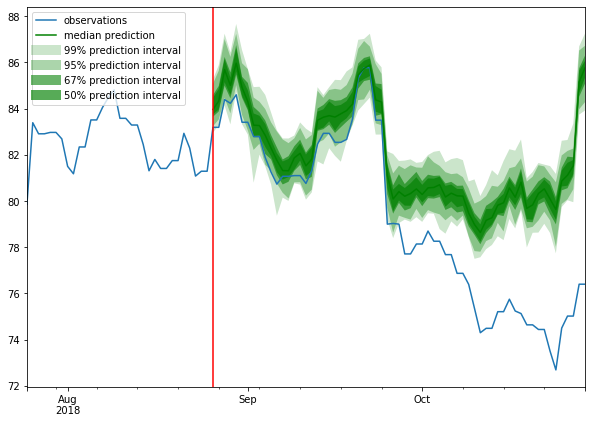

<Figure size 432x288 with 0 Axes>

In [25]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 324
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(1)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)